### **Agrupación y Segmentación de Vecindarios en la Ciudad de Toronto, Canadá**

In [ ]:
#importando Librerías
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import requests
!pip install geocoder
import geocoder # import geocoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98 kB 3.5 MB/s 


In [ ]:
#Extrayendo data de Wikipedia
linkpost= "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=prev&oldid=926287641%20%20%20Me%20gusta%203%20%20Responder%203%20%20M%C3%A1s"

In [ ]:
#Transformando los datos -  combinarán en una fila con los vecindarios separados con una coma
page = requests.get(linkpost)
soup = BeautifulSoup(page.content, 'html.parser')

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# Imprimir (table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [ ]:
#Se imprime 11 filas
df.head(11)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [ ]:
# Se Imprime número de filas y marco de datos
df.shape

(103, 3)

In [ ]:
# Usando Geocoder Python 
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [ ]:
# Fusionando Datos
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [ ]:
# Averigüemos cuántos vecindarios hay en cada municipio
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

In [ ]:
df_toronto = df
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [ ]:
# Cree una lista y almacene todos los nombres de municipios únicos
boroughs = df_toronto['Borough'].unique().tolist()

In [ ]:
# Obtenemos la latitud y la longitud de Toronto tomando la media de la latitud/longitud de todos los códigos postales
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.704607733980595, -79.39715291165048


In [ ]:
# Obtenemos la latitud y la longitud de Toronto tomando la media de la latitud/longitud de todos los códigos postales
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

In [ ]:
import folium

In [ ]:
# Creando Mapa de Segmentación 
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

**Usando el algoritmo de agrupamiento de KMeans**

In [ ]:
df_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [ ]:
# Columna "Vecindario" del marco de datos

X = df_toronto.drop(['PostalCode','Borough','Neighborhood'], axis=1)

In [ ]:
# Matplotlib y módulos de trazado asociados
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

#importar k-medias desde la etapa de agrupación
from sklearn.cluster import KMeans

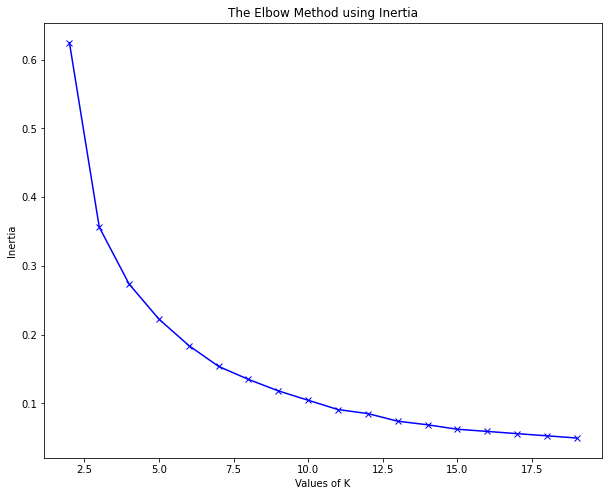

In [ ]:
# Hallando el valor 'k' por el método del codo
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

**El mejor valor para k es 4!**

In [ ]:
k=4
kmeans = KMeans(n_clusters = k,random_state=0).fit(X)
kmeans.labels_
df_toronto.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
# Impimir vecindario Tororonto
df_toronto

,Cluster Labels,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,3,M3A,North York,Parkwoods,43.753259,-79.329656
1,3,M4A,North York,Victoria Village,43.725882,-79.315572
2,0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,0,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...,...
98,1,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,0,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,0,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,1,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [ ]:
# Creando el mapa de Agrupación
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood'], df_toronto['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters